In [1]:
import pandas as pd

# Load dataset
data = pd.read_csv('../UpdatedFilteredUsedData.csv')
data.head()

,Year,Make,Model,Price,Mileage,Location,Additional,Fuel Type,Car Type,Scraping Time,Source
0,2021,Audi,RS7,214880,21601,NSW,*Excl. Govt. Charges,Petrol,hatch,1712976689,Drive
1,2021,Audi,RS7,214880,21601,NSW,*Excl. Govt. Charges,Petrol,hatch,1713581171,Drive
2,2021,Audi,RS7,214880,21601,NSW,*Excl. Govt. Charges,Petrol,hatch,1714183161,Drive
3,2021,Audi,RS7,214880,21601,NSW,*Excl. Govt. Charges,Petrol,hatch,1714787697,Drive
4,2021,Audi,RS7,214880,21601,NSW,*Excl. Govt. Charges,Petrol,hatch,1715394085,Drive


In [2]:
# Define the columns to check for duplicates
columns_to_check = ['Year', 'Make', 'Model', 'Price', 'Mileage', 'Location']

before_removal = len(data)

# Drop duplicates based on the specified columns
data_unique = data.drop_duplicates(subset=columns_to_check)

after_removal = len(data_unique)

removed = before_removal - after_removal

# Update data
data = data_unique
data['Fuel Type Adjusted'] = data.apply(lambda x:
                                        ('Electric' if x['Fuel Type'] == 'Electric' else
                                         ('Hybrid' if x['Fuel Type'] == 'Hybrid' else 'Conventional')),
                                        axis=1)

# Current year to calculate the age of the vehicles
current_year = pd.Timestamp.now().year

# Add 'Age' column
data['Age'] = current_year - data['Year']

removed, after_removal

(622690, 346936)

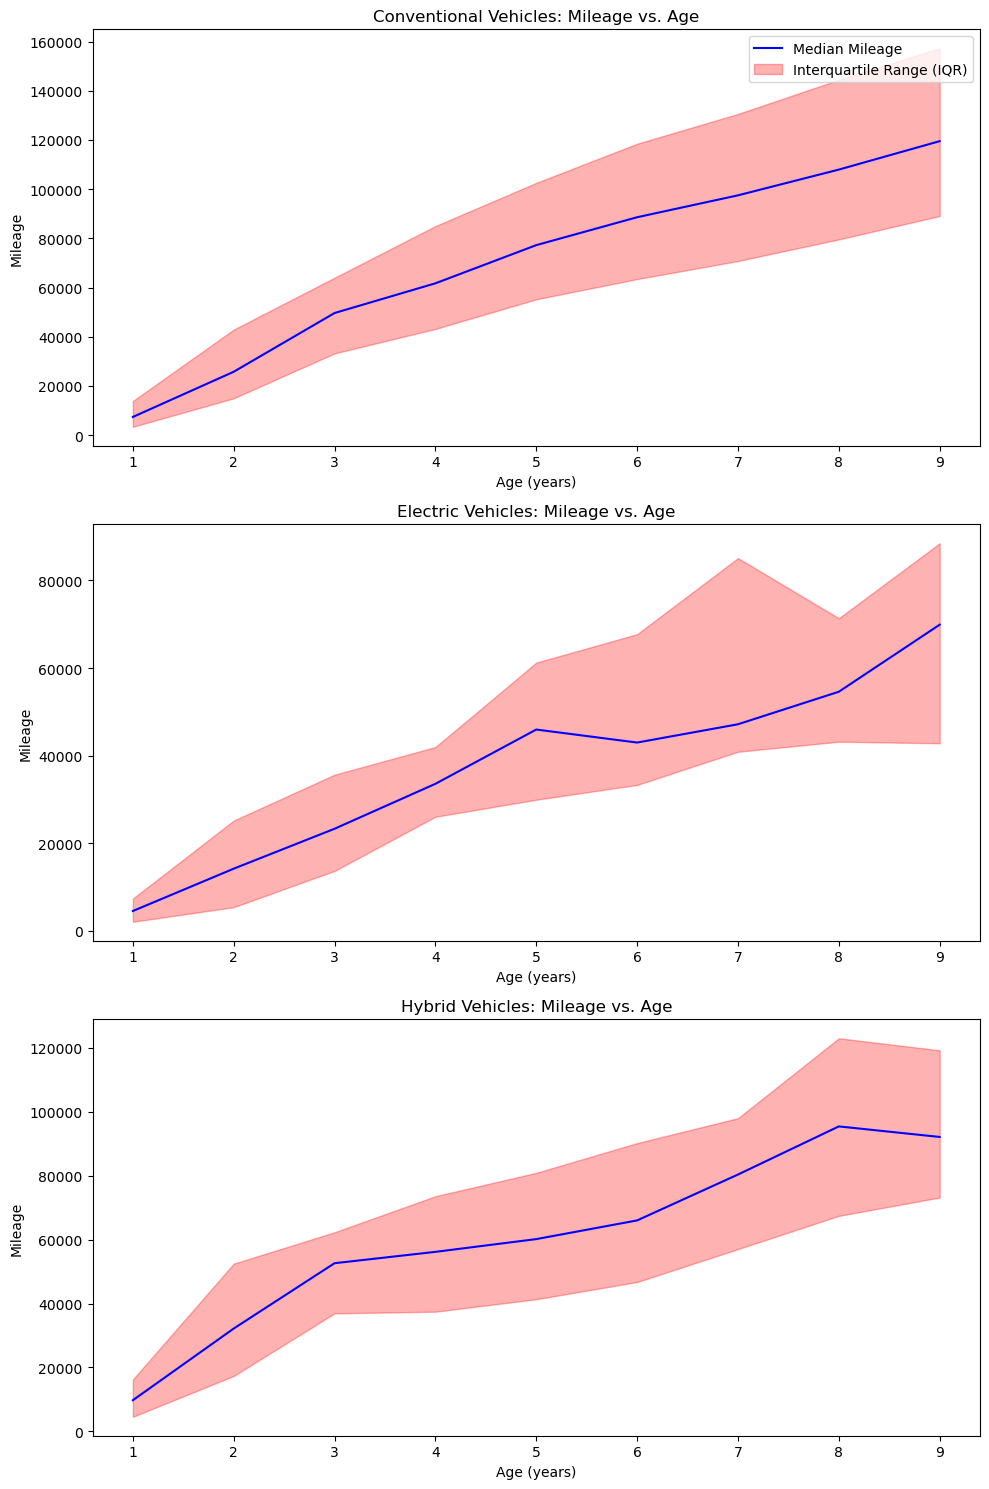

In [3]:
import numpy as np
import matplotlib.pyplot as plt

data = data[data['Age'] > 0]

# Group data by 'Fuel Type Adjusted' and 'Age', then calculate the median and percentiles for each group
grouped_data = data.groupby(['Fuel Type Adjusted', 'Age']).agg(
    median_mileage=('Mileage', 'median'),
    percentile_25=('Mileage', lambda x: np.percentile(x, 25)),
    percentile_75=('Mileage', lambda x: np.percentile(x, 75))
).reset_index()

# Begin plotting the updated version
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

fuel_types = data['Fuel Type Adjusted'].unique()

for index, fuel_type in enumerate(fuel_types):
    subset = grouped_data[grouped_data['Fuel Type Adjusted'] == fuel_type]
    if subset.empty:
        continue
    
    # Sorting the subset by 'Age' to ensure lines are plotted correctly
    subset = subset.sort_values(by='Age')
    
    # Plotting the median mileage as a line
    axs[index].plot(subset['Age'], subset['median_mileage'], color='blue', label='Median Mileage')
    
    # Plotting the area between the 25th and 75th percentiles
    axs[index].fill_between(subset['Age'], subset['percentile_25'], subset['percentile_75'], color='red', alpha=0.3, label='Interquartile Range (IQR)')
    
    axs[index].set_title(f'{fuel_type} Vehicles: Mileage vs. Age')
    axs[index].set_xlabel('Age (years)')
    axs[index].set_ylabel('Mileage')
    
    # Add legend to the first plot
    if index == 0:
        axs[index].legend()

plt.tight_layout()
plt.show()


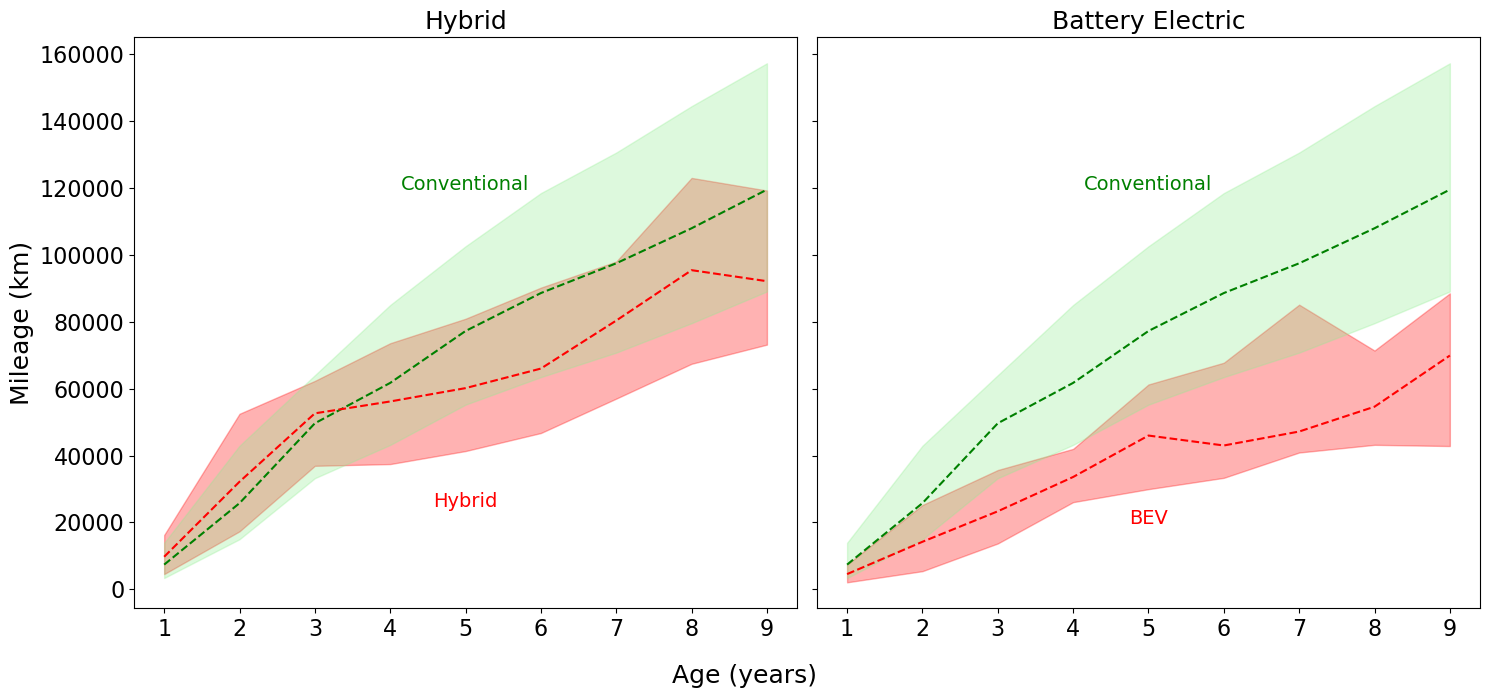

In [4]:
# Begin plotting for combined fuel types
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)  # 1 row, 2 columns, shared y-axis

# Plot each fuel type in different subplots
fuel_types = ['Hybrid', 'Electric']  # Specify which fuel types to plot separately
conventional_data = grouped_data[grouped_data['Fuel Type Adjusted'] == 'Conventional']

for index, fuel_type in enumerate(fuel_types):
    subset = grouped_data[grouped_data['Fuel Type Adjusted'] == fuel_type]
    if subset.empty:
        continue

    # Sorting the subsets by 'Age'
    subset = subset.sort_values(by='Age')
    conventional_subset = conventional_data.sort_values(by='Age')

    # Plotting the conventional data on each subplot with a specific color
    axs[index].plot(conventional_subset['Age'], conventional_subset['median_mileage'], color='green', label='Conventional Median Mileage', linestyle='--')

    # Plotting the specific fuel type data
    axs[index].plot(subset['Age'], subset['median_mileage'], color='red', label=f'{fuel_type} Median Mileage', linestyle='--')

    # Plotting the area between the 25th and 75th percentiles for each type
    axs[index].fill_between(subset['Age'], subset['percentile_25'], subset['percentile_75'], color='red', alpha=0.3, label=f'{fuel_type} IQR')
    axs[index].fill_between(conventional_subset['Age'], conventional_subset['percentile_25'], conventional_subset['percentile_75'], color='lightgreen', alpha=0.3, label='Conventional IQR')
    
    if fuel_type == "Electric":
        axs[index].set_title('Battery Electric', fontsize=18)
    else:
        axs[index].set_title(f'{fuel_type}', fontsize=18)
    
    #axs[index].set_xlabel('Age (years)')

    # Only set the y-label for the first plot, since they share the y-axis
    if index == 0:
        axs[index].set_ylabel('Mileage (km)', fontsize=18)
        
    # Increase tick label size
    axs[index].tick_params(axis='both', which='major', labelsize=16)

    #axs[index].legend()
    # Annotating Conventional and Fuel Type areas
    if fuel_type == "Electric":
        fuel_type = "BEV"
    axs[index].text(conventional_subset['Age'].mean(), conventional_subset['median_mileage'].max(),
                    'Conventional', color='green', fontsize=14, ha='center')
    axs[index].text(subset['Age'].mean(), subset['median_mileage'].min() + 15000,
                    fuel_type, color='red', fontsize=14, ha='center')

fig.supxlabel('Age (years)', fontsize=18)
    
plt.tight_layout()
plt.show()


In [5]:
# Update data for Tesla and Non-Tesla BEVs
data = data_unique
data['Fuel Type Adjusted'] = data.apply(lambda x:
                                        'Electric (Tesla)' if 'Tesla' in x['Make'] and x['Fuel Type'] == 'Electric' else
                                        ('Electric (Non-Tesla)' if x['Fuel Type'] == 'Electric' else
                                         ('Hybrid' if x['Fuel Type'] == 'Hybrid' else 'Conventional')),
                                        axis=1)

# Current year to calculate the age of the vehicles
current_year = pd.Timestamp.now().year

# Add 'Age' column
data['Age'] = current_year - data['Year']
data = data[data['Age'] > 0]

Statistics for Conventional:
Gradient (slope): 14439.01 ± 36.17
Intercept: 4893.02 ± 196.37
R^2: 0.33
P-value (Age): 0.0

Statistics for Hybrid:
Gradient (slope): 10631.50 ± 105.30
Intercept: 13093.72 ± 397.23
R^2: 0.33
P-value (Age): 0.0

Statistics for Electric (Non-Tesla):
Gradient (slope): 8947.89 ± 136.34
Intercept: -3643.58 ± 352.85
R^2: 0.53
P-value (Age): 0.0

Statistics for Electric (Tesla):
Gradient (slope): 7395.36 ± 264.12
Intercept: 9887.47 ± 947.75
R^2: 0.44
P-value (Age): 2.89661477438978e-128



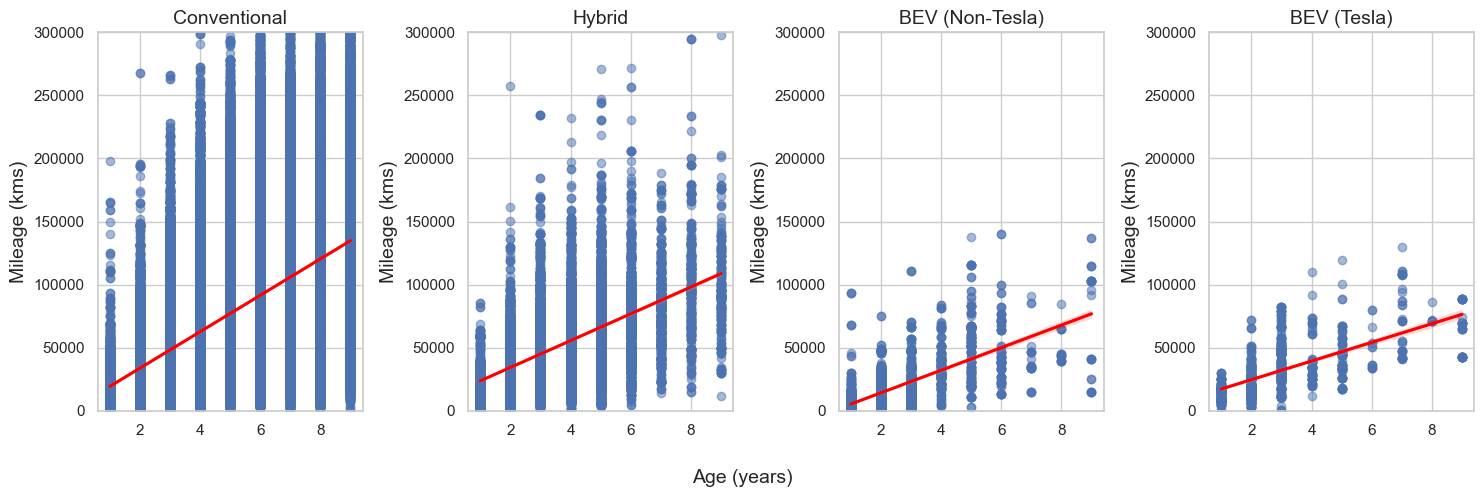

In [6]:
import seaborn as sns
import statsmodels.api as sm

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with subplots in a single row
fig, axs = plt.subplots(1, len(data['Fuel Type Adjusted'].unique()), figsize=(15, 5))
axs = axs.flatten()  # Flatten the array to ensure it's iterable

# List of unique fuel types adjusted
#fuel_types = data['Fuel Type Adjusted'].unique()
fuel_types = ['Conventional', 'Hybrid', 'Electric (Non-Tesla)', 'Electric (Tesla)']

# Loop through each fuel type and create a scatter plot with a regression line
for i, fuel_type in enumerate(fuel_types):
    # Filter the data for the current fuel type
    subset = data[data['Fuel Type Adjusted'] == fuel_type]
    
    # Create a regplot on the appropriate subplot
    sns.regplot(x='Age', y='Mileage', data=subset, ax=axs[i], 
                line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
    
    # Set plot limits for mileage
    axs[i].set_ylim(0, 300000)  # Adjusting the y-axis limit to 0 to 300,000 kms
    axs[i].grid(True)
    
    # Setting titles and labels
    type_fuel = fuel_type
    if fuel_type == 'Electric (Non-Tesla)':
        type_fuel = 'BEV (Non-Tesla)'
    if fuel_type == 'Electric (Tesla)':
        type_fuel = 'BEV (Tesla)'
    
    axs[i].set_title(f'{type_fuel}', fontsize=14)
    #axs[i].set_xlabel('Age (years)')
    axs[i].set_ylabel('Mileage (kms)', fontsize=14)
    # Only display the y-axis label for the first plot
    # if i == 0:
    #     axs[i].set_ylabel('Mileage (kms)', fontsize=14)
    # else:
    #     axs[i].yaxis.set_visible(False)  # Hide the y-axis for other subplots
    axs[i].set_xlabel('')
    
    axs[i].grid(True)

    # Prepare the data for linear regression using statsmodels
    X = subset['Age']
    y = subset['Mileage']
    
    # Add a constant to the independent variable
    X = sm.add_constant(X)

    # Fit the linear model
    model = sm.OLS(y, X).fit()
    
   # Extract gradient (slope) and intercept with their standard errors
    gradient = model.params['Age']
    intercept = model.params['const']
    gradient_se = model.bse['Age']
    intercept_se = model.bse['const']
    
    # Print the statistics
    print(f'Statistics for {fuel_type}:')
    print(f"Gradient (slope): {gradient:.2f} ± {gradient_se:.2f}")
    print(f"Intercept: {intercept:.2f} ± {intercept_se:.2f}")
    print(f"R^2: {model.rsquared:.2f}")
    print(f"P-value (Age): {model.pvalues['Age']}\n")

# Adjust layout to prevent overlap
fig.supxlabel('Age (years)', fontsize=14)
plt.tight_layout()
plt.show()

Statistics for Conventional:
Gradient (slope): 14632.10 ± 52.91
Intercept: 2798.17 ± 273.84
R^2: 0.33
P-value (Age): 0.0

Statistics for Hybrid:
Gradient (slope): 13306.95 ± 158.37
Intercept: 5921.67 ± 516.16
R^2: 0.39
P-value (Age): 0.0

Statistics for Electric (Non-Tesla):
Gradient (slope): 10471.11 ± 219.74
Intercept: -6547.56 ± 496.86
R^2: 0.52
P-value (Age): 0.0

Statistics for Electric (Tesla):
Gradient (slope): 9131.62 ± 384.70
Intercept: 5011.20 ± 1002.70
R^2: 0.62
P-value (Age): 2.704089105098706e-74



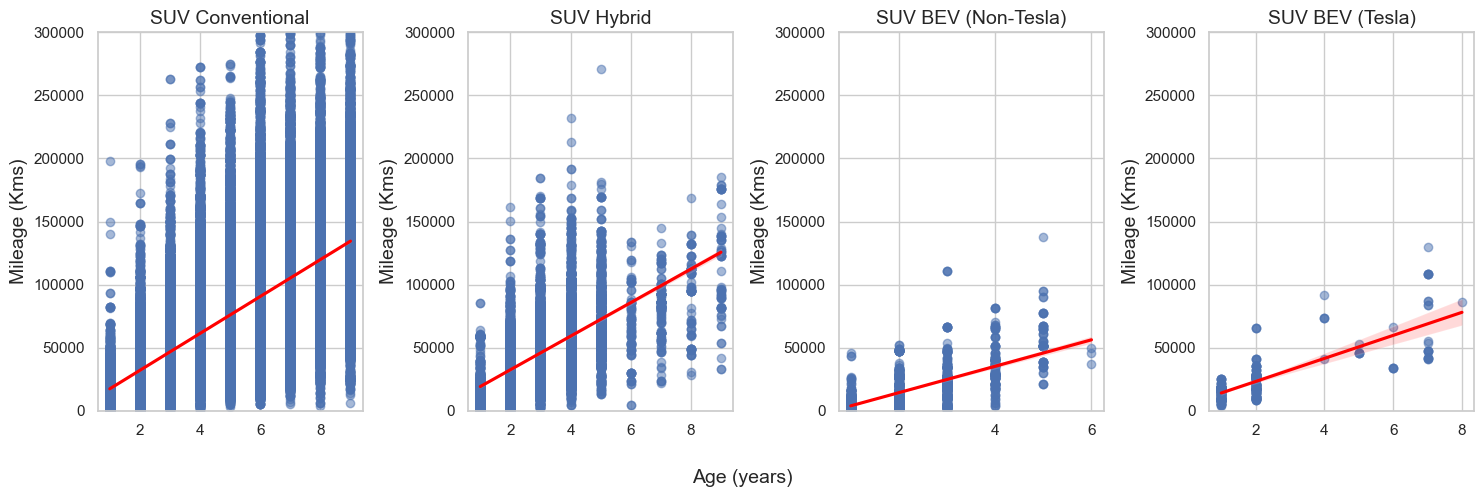

In [7]:
# Filter data to include only SUVs
suv_data = data[data['Car Type'] == 'suv']

# List of unique fuel types adjusted for SUVs
#fuel_types = suv_data['Fuel Type Adjusted'].unique()
fuel_types = ['Conventional', 'Hybrid', 'Electric (Non-Tesla)', 'Electric (Tesla)']

# Create a figure for SUV plots
fig, axs = plt.subplots(1, len(fuel_types), figsize=(15, 5))  # Adjust to have all plots in a single row
axs = axs.flatten()  # Flatten the array to ensure it's iterable

# Loop through each fuel type and plot for SUVs
for i, fuel_type in enumerate(fuel_types):
    # Filter the SUV data for the current fuel type
    subset = suv_data[suv_data['Fuel Type Adjusted'] == fuel_type]
    
    # Create a regplot on the appropriate subplot
    sns.regplot(x='Age', y='Mileage', data=subset, ax=axs[i], 
                line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
    
    # Set plot limits for mileage
    axs[i].set_ylim(0, 300000)  # Adjusting the y-axis limit to 0 to 300,000 kms
    
    # Setting titles and labels
    type_fuel = fuel_type
    if fuel_type == 'Electric (Non-Tesla)':
        type_fuel = 'BEV (Non-Tesla)'
    if fuel_type == 'Electric (Tesla)':
        type_fuel = 'BEV (Tesla)'
    
    axs[i].set_title(f'SUV {type_fuel}', fontsize=14)
    #axs[i].set_xlabel('Age (Years)')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Mileage (Kms)', fontsize=14)

    # Prepare the data for linear regression using statsmodels
    X = subset['Age']
    y = subset['Mileage']
    
    # Add a constant to the independent variable
    X = sm.add_constant(X)

    # Fit the linear model
    model = sm.OLS(y, X).fit()
    
    # Extract gradient (slope) and intercept with their standard errors
    gradient = model.params['Age']
    intercept = model.params['const']
    gradient_se = model.bse['Age']
    intercept_se = model.bse['const']
    
    # Print the statistics
    print(f'Statistics for {fuel_type}:')
    print(f"Gradient (slope): {gradient:.2f} ± {gradient_se:.2f}")
    print(f"Intercept: {intercept:.2f} ± {intercept_se:.2f}")
    print(f"R^2: {model.rsquared:.2f}")
    print(f"P-value (Age): {model.pvalues['Age']}\n")

# Adjust layout to prevent overlap
fig.supxlabel('Age (years)', fontsize=14)
plt.tight_layout()
plt.show()
